This notebook is meant to walk through the process of mosaicing images to detect transient sources in TTE data. 

In [1]:
import batanalysis as ba
from swifttools.swift_too import GUANO 

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

In [2]:
guano = GUANO(begin="2021-06-26", end="2021-06-27", limit=100)
print(guano)

+--------------+----------------------------+------------+---------------------+----------------+
| Trigger Type |               Trigger Time | Offset (s) | Window Duration (s) | Observation ID |
+--------------+----------------------------+------------+---------------------+----------------+
|      GBM GRB | 2021-06-26 23:46:24.000001 |         50 |                 200 |    00014135005 |
|      GBM GRB |        2021-06-26 08:16:15 |         50 |                 200 |    00036799012 |
|      GBM GRB |        2021-06-26 00:00:00 |         50 |                 200 |    00035785004 |
+--------------+----------------------------+------------+---------------------+----------------+


In [3]:
trigger=guano.entries[1]

In [4]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

download = ba.download_swiftdata(guano[1].obsid, quiet=False)

datadir=ba.datadir().joinpath(guano[1].obsid)

print(download)
print(ba.datadir())

{'00036799012': {'obsid': '00036799012', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/00036799012'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='00036799012',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}
/private/tmp/batdata/download_examples


/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: SWIFT_TLE_ARCHIVE.txt.21182.87130952.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw00036799012pat.fits.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw00036799012pjb.par.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw00036799012pob.cat.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw00036799012ppr

In [5]:
event=ba.BatEvent(guano[1].obsid, is_guano=True)

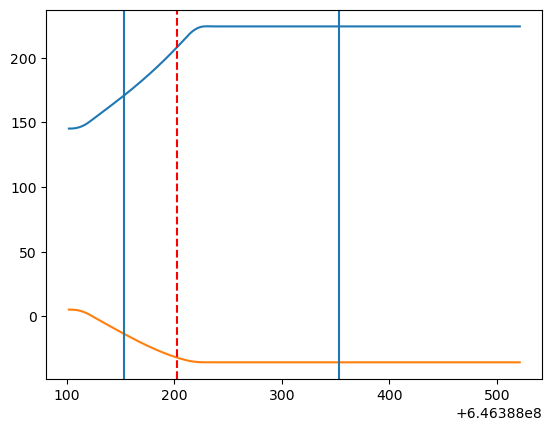

In [24]:
plt.plot(event.attitude.time, event.attitude.ra)
plt.plot(event.attitude.time, event.attitude.dec)
plt.axvline(trigger.triggertime.met, color='r', ls='--')
plt.axvline(event.data.time.min().value)
plt.axvline(event.data.time.max().value)

In [20]:
slew_idx=np.where((event.attitude.time>event.data.time.min()) & (event.attitude.time<event.data.time.max()) & (~ event.attitude.is_10arcmin_settled) & (~ event.attitude.is_settled))
settled_idx=np.where((event.attitude.time>event.data.time.min()) & (event.attitude.time<event.data.time.max()) & (event.attitude.is_10arcmin_settled) & (event.attitude.is_settled))

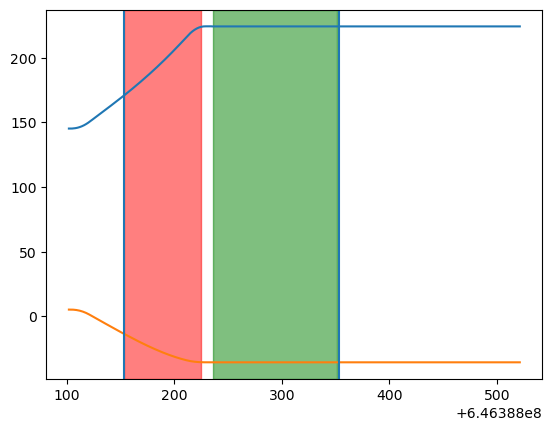

In [12]:
plt.plot(event.attitude.time, event.attitude.ra)
plt.plot(event.attitude.time, event.attitude.dec)
plt.axvline(event.data.time.min().value)
plt.axvline(event.data.time.max().value)
plt.axvspan(event.attitude.time[slew_idx].min().value, event.attitude.time[slew_idx].max().value, color='red', alpha=0.5)
plt.axvspan(event.attitude.time[settled_idx].min().value, event.attitude.time[settled_idx].max().value, color='green', alpha=0.5)

In [14]:
#create a single skyview for the time period where we are settled
energybins=[ 15.,  25.,  50., 100., 350]*u.keV
timebin=u.Quantity([event.attitude.time[settled_idx].min(), event.attitude.time[settled_idx].max()])
settled_skyview = event.create_skyview(timebins=timebin, energybins=energybins)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]


{'TIME_START': <Quantity [6.46388236e+08] s>, 'TIME_STOP': <Quantity [6.46388351e+08] s>, 'TIME_CENT': <Quantity [6.46388294e+08] s>} {'INDEX': array([1, 2, 3, 4]), 'E_MIN': <Quantity [ 15.,  25.,  50., 100.] keV>, 'E_MAX': <Quantity [ 25.,  50., 100., 350.] keV>}


(<Axes: xlabel='SKYX', ylabel='SKYY'>,
 <matplotlib.collections.QuadMesh at 0x16cbeb690>)

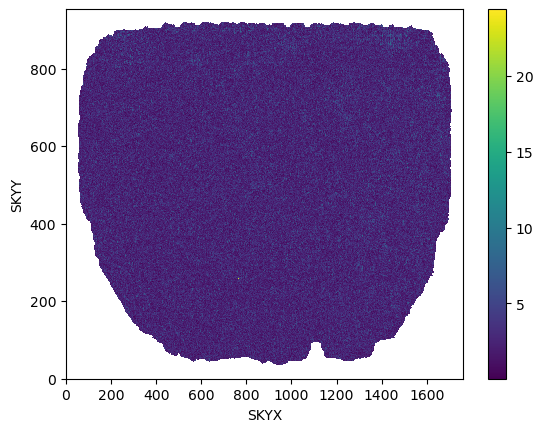

In [16]:
print(settled_skyview.sky_img.tbins, settled_skyview.sky_img.ebins)
settled_skyview.snr_img.plot()

In [17]:
settled_skyview.detect_sources()

CATNUM,NAME,SKYCOORD,ALWAYS_CLEAN,TIME,TIME_STOP,EXPOSURE,IMX,IMY,IMX_ERR,IMY_ERR,IMXPIX,IMYPIX,RA_OBJ_ERR,DEC_OBJ_ERR,ERR_RAD,IMX_FWHM,IMY_FWHM,IMX_FHWM_ERR,IMY_FHWM_ERR,THETA,PHI,GRMCLON,GRMCLAT,COUNTS,COUNTS_ERR,CENT_COUNTS,CONTAM_COUNTS,BKG,BKG_ERR,BKG_VAR,BKG_CELL,BKG_FIT,SNR,CENT_SNR,NPIXSOU,NPIXBKG,DETECT_METHOD,CHI2,DOF,CHI2_NU,DETECT_STATUS,CONSTRAINT_FLAG,SRC_WINDOW_RAD,BKG_WINDOW_RAD,NGOODPIX,BAT_ZOBJ,PCODEFR,RA_PER_IMX,DEC_PER_IMX,RA_PER_IMY,DEC_PER_IMY,GAINAPP,CLOCKAPP,BTOFFAPP,FFAPP,NFAPP,PCODEAPP,NGPIXAPP,MSKWTAPP,BDISTAPP,BACKAPP,ACOLAPP
,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int16,str30,SkyCoord,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],float64[4],int32,int32,int32,float64[4],float64[4],float64[4],int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32
442,3C 279,"194.04649982652438,-5.789299040150063",False,646388236.4006,646388351.4006,115.0,0.6987018298702543,0.5050656530252894,0.0,0.0,547.074539389235,717.1191544302195,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,40.765752786372474,-35.86177142111808,-26.79677281362969,31.950514875296058,2.6561185656499835 .. 25.637280023175705,76.93295706793509 .. 53.246186638657534,0.12407751747519766 .. -0.0828337037809225,-2.4396187294339744 .. -25.654255325522293,0.004828732524802339 .. 0.0467008912809225,0.07179254303949398 .. 0.0495697828341643,0.18089568614959717 .. 0.1251700222492218,0.026428695768117905 .. 0.026428695768117905,0.004828732524802339 .. 0.0467008912809225,14.683150395601064 .. 204.8196490061349,0.6859064476119568 .. -0.6617695059284652,0,0,2,87.67333085164849 .. 83.54683736100449,109.0 .. 109.0,0.804342484877509 .. 0.7664847464312339,0,11,6,30,15648,10000000.0,0.38671875,3.149586859763076,36.687277215285974,-39.67771948509835,-7.018823092508342,1,0,1,1,0,1,1,1,0,0,1
0,TRIGGER 35019,"194.04624982709458,-5.789189040186215",False,646388236.4006,646388351.4006,115.0,0.6987060984485712,0.5050722926351795,0.0,0.0,547.0725079708544,717.1223150185465,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,40.7659943262532,-35.86196283787413,-26.79707591556632,31.950603308773676,-2.444457326377971 .. -25.701059931450295,76.93282014445849 .. 53.246037540648764,0.1024775542318821 .. -0.033236192306503654,2.660936579612969 .. 25.683877457188455,0.026428695768117905 .. -0.0028966201934963465,0.0 .. 0.0,0.18089568614959717 .. 0.1251700222492218,0.026428695768117905 .. 0.026428695768117905,0.026428695768117905 .. -0.0028966201934963465,-13.513076947321194 .. -205.32919519881352,0.5665008183066078 .. -0.265528372602892,0,0,2,87.67333085164849 .. 83.54683736100449,109.0 .. 109.0,0.804342484877509 .. 0.7664847464312339,0,11,6,30,15648,10000000.0,0.38671875,3.1496912811235234,36.68709841964102,-39.677498165247016,-7.018812067549618,1,0,1,1,0,1,1,1,0,0,1
3,Sco X-1,"244.97950012913594,-15.640201682360678",True,646388236.4006,646388351.4006,115.0,0.2394609875418649,-0.4558485896389482,0.0,0.0,765.6325923354655,259.67355971315567,0.0,0.0,0.0,0.006529800274994075,0.006529800274994075,0.0,0.0,27.244707951764788,62.28668731699179,24.505803579712925,12.292063674724444,2.738185567710774 .. -0.07112694851108478,0.1784613616947662 .. 0.11114866433929672,2.550324800497781 .. -0.07522765556236868,0.042448637002218764 .. 0.027864374312368677,0.042448637002218764 .. 0.027864374312368677,0.0588786543162455 .. 0.03691024308576989,0.1583869904279709 .. 0.09830424934625626,0.033192701637744904 .. 0.033192701637744904,0.042448637002218764 .. 0.027864374312368677,17.287944927244574 .. -0.7235389007504133,16.10185782056124 .. -0.7652533442109397,0,0,2,121.23426697739703 .. 96.92066068102251,111.0 .. 111.0,1.092200603399